## Setup

In [1]:
%pylab inline
from spring_helper import *
from doublet_detector import *
from collections import defaultdict

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rc('font', size=14)
plt.rcParams['pdf.fonttype'] = 42

## Load data

In [3]:

sample_name = ['P9A', 'P11A', 'P11B', 'P12A']

min_tot = [1000 for s in sample_name] # initial guess for total transcript counts threshold
nSamp = len(sample_name)
input_path = 'raw_counts/'



In [4]:
# D stores all the data; one entry per library
D = {}

for j,s in enumerate(sample_name):
    D[s] = {}
    D[s]['meta'] = {'min_tot': min_tot[j]}
    

In [5]:
# load counts matrices -- try to load from npz file (fast), 
# otherwise load from text file (slow) and build npz file for next time

for s in sample_name:
    print '_________________', s

    if os.path.isfile(input_path + s + '.raw_counts.unfiltered.npz'):
        print 'Loading from npz file'
        D[s]['E'] = scipy.sparse.load_npz(input_path + s + '.raw_counts.unfiltered.npz')
    else:
        print 'Loading from text file'
        E,cell_bcs = load_text(file_opener(input_path + s + '.counts.tsv.gz'), delim = '\t', load_cell_bcs=True)
        D[s]['E'] = E
        D[s]['cell_bcs'] = cell_bcs
        scipy.sparse.save_npz(input_path + s + '.raw_counts.unfiltered.npz', D[s]['E'], compressed = True)
    print D[s]['E'].shape
    



_________________ P9A
Loading from text file
(1817, 28205)
_________________ P11A
Loading from text file
(1832, 28205)
_________________ P11B
Loading from text file
(1891, 28205)
_________________ P12A
Loading from text file
(1393, 28205)


In [6]:
gene_list = np.array(load_genes(input_path + 'genes.txt'))

## Filter cells by total counts

P9A 1446 / 1817 2409.0 2555.26279391
P11A 1426 / 1832 1764.5 1885.15217391
P11B 1096 / 1891 1767.5 1902.42518248
P12A 1081 / 1393 1939.0 2291.71785384


/opt/local/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


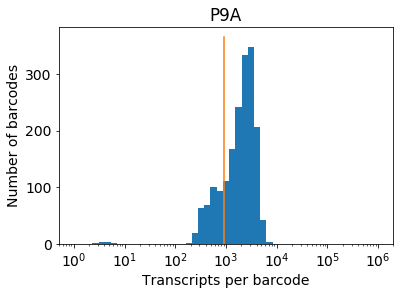

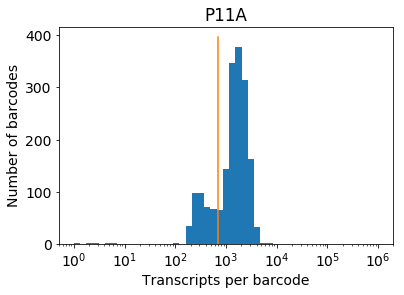

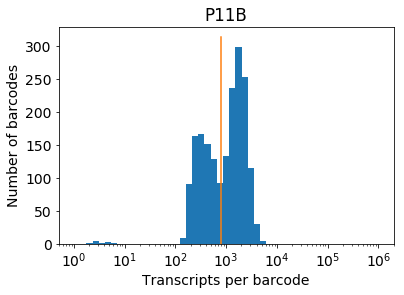

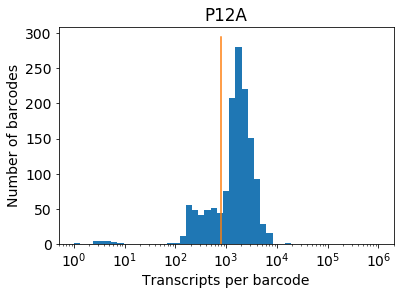

In [7]:
# plot total counts histograms - don't actually filter out any barcodes yet


# adjust total counts thresholds
D['P9A']['meta']['min_tot'] = 900
D['P11A']['meta']['min_tot'] = 700
D['P11B']['meta']['min_tot'] = 800
D['P12A']['meta']['min_tot'] = 800

for s in sample_name:
    D[s]['total_counts'] = np.sum(D[s]['E'], axis=1).A[:,0]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(D[s]['total_counts'], bins=np.logspace(0, 6, 50))
    ax.set_xscale('log')
    ax.set_xlabel('Transcripts per barcode')
    ax.set_ylabel('Number of barcodes')

    
    ax.plot([D[s]['meta']['min_tot'],D[s]['meta']['min_tot']],ax.get_ylim());
    title(s)


    ix = D[s]['total_counts'] >= D[s]['meta']['min_tot']
    print s, np.sum(ix), '/', D[s]['E'].shape[0], np.median(D[s]['total_counts'][ix]), np.mean(D[s]['total_counts'][ix])


In [8]:
D[s]['cell_bcs'].shape, D[s]['total_counts'].shape
    

((1393,), (1393,))

In [9]:
# Actually filter out low-count barcodes

for s in sample_name:
    print '---  %s ---' %s
    print 'Pre-filter: %i barcodes' %D[s]['E'].shape[0]
    D[s]['cell_index'] = np.arange(D[s]['E'].shape[0])
    tmpfilt = np.nonzero(D[s]['total_counts'] >= D[s]['meta']['min_tot'])[0]
    D[s] = filter_dict(D[s], tmpfilt)
    print 'Post-filter: %i barcodes' %D[s]['E'].shape[0]
    
del tmpfilt

---  P9A ---
Pre-filter: 1817 barcodes
Post-filter: 1446 barcodes
---  P11A ---
Pre-filter: 1832 barcodes
Post-filter: 1426 barcodes
---  P11B ---
Pre-filter: 1891 barcodes
Post-filter: 1096 barcodes
---  P12A ---
Pre-filter: 1393 barcodes
Post-filter: 1081 barcodes


## Filter cells by mito fraction

In [10]:
# get mitochondrial genes

mt_ix = [i for i,g in enumerate(gene_list) if g.startswith('mt-')]
print [gene_list[i] for i in mt_ix]

['mt-Atp6', 'mt-Atp8', 'mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd3', 'mt-Nd4', 'mt-Nd4l', 'mt-Nd5', 'mt-Nd6']


1446 1303
1426 1384
1096 1056
1081 1047


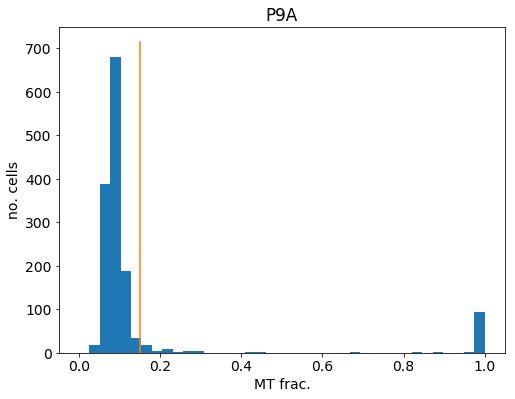

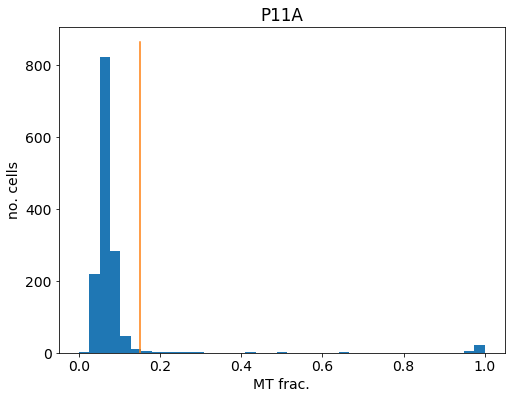

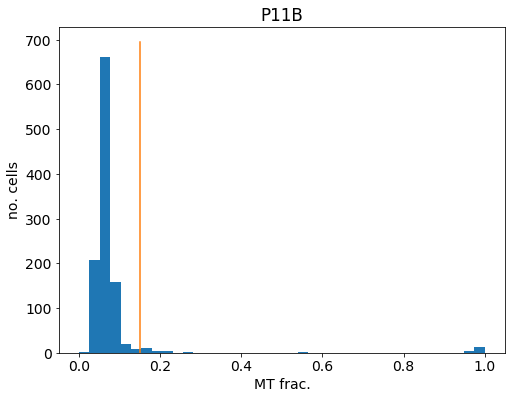

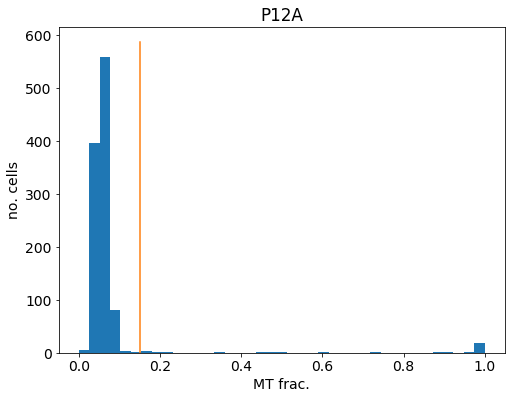

In [11]:
# plot mito-gene frac histograms - don't actually filter out any cells yet

# set mito-gene frac threshold
for s in sample_name:
    D[s]['meta']['max_mt'] = 0.15

for s in sample_name:
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, xscale='linear', yscale='linear',
        xlabel='MT frac.', ylabel='no. cells')

    D[s]['mito_frac'] = np.sum(D[s]['E'][:,mt_ix], axis=1).A[:,0] / np.sum(D[s]['E'], axis=1,dtype=float).A[:,0]

    ax.hist(D[s]['mito_frac'], cumulative=False, 
            bins=np.linspace(0, 1, 40))

    ax.plot([D[s]['meta']['max_mt'],D[s]['meta']['max_mt']],ax.get_ylim());
    title(s)

    print D[s]['E'].shape[0], np.sum(D[s]['mito_frac'] <= D[s]['meta']['max_mt'])


In [12]:
# Actually filter out mito-high cells

for s in sample_name:
    print '---  %s ---' %s
    print 'Pre-filter: %i barcodes' %D[s]['E'].shape[0]
    tmpfilt = np.nonzero(D[s]['mito_frac'] <= D[s]['meta']['max_mt'])[0]
    D[s] = filter_dict(D[s], tmpfilt)
    print 'Post-filter: %i barcodes' %D[s]['E'].shape[0]
    
del tmpfilt

---  P9A ---
Pre-filter: 1446 barcodes
Post-filter: 1303 barcodes
---  P11A ---
Pre-filter: 1426 barcodes
Post-filter: 1384 barcodes
---  P11B ---
Pre-filter: 1096 barcodes
Post-filter: 1056 barcodes
---  P12A ---
Pre-filter: 1081 barcodes
Post-filter: 1047 barcodes


## Merge data, normalize

In [13]:
# create master dataset (all SPRING subsets will refer back to this)

# build sample index
samp_id_flat = np.array([],dtype=str)
for s in sample_name:
    samp_id_flat = np.append(samp_id_flat, [s] * D[s]['E'].shape[0])

# build flat cell BC list
cell_bcs_flat = np.array([],dtype=str)
for s in sample_name:
    cell_bcs_flat = np.append(cell_bcs_flat, D[s]['cell_bcs'])

# merge quality metrics
total_counts = np.zeros(len(samp_id_flat), dtype=int)
mito_frac = np.zeros(len(samp_id_flat), dtype=float)
for s in sample_name:
    total_counts[samp_id_flat == s] = D[s]['total_counts']
    mito_frac[samp_id_flat == s] = D[s]['mito_frac']

# merge counts matrices
E = scipy.sparse.vstack([D[s]['E'] for s in sample_name]).tocsc()


In [14]:
# normalize by total counts
E = tot_counts_norm(E)[0]

## Save base directory files

In [15]:
# Set path for saving data -- you'll have to change this for your own setup.
# This path should be a subdirectory of your local copy of SPRING,
# specifically, {path_to_SPRING}/datasets/{main_dataset_name}. 
# See example below, where springViewer_1_6_dev.html is located in ../

main_spring_dir = '../datasets/hpc/'

if not os.path.exists(main_spring_dir):
    os.makedirs(main_spring_dir)
    


In [16]:
np.savetxt(main_spring_dir + 'genes.txt', gene_list, fmt='%s')
np.savetxt(main_spring_dir + 'samp_id_flat.txt', samp_id_flat, fmt='%s')
np.savetxt(main_spring_dir + 'cell_bcs_flat.txt', cell_bcs_flat, fmt='%s')
np.savetxt(main_spring_dir + 'total_counts.txt', total_counts)

In [17]:
# save master expression matrices

print 'Saving hdf5 file for fast gene loading...'
save_hdf5_genes(E, gene_list, main_spring_dir + 'counts_norm_sparse_genes.hdf5')

##############
print 'Saving hdf5 file for fast cell loading...'
save_hdf5_cells(E, main_spring_dir + 'counts_norm_sparse_cells.hdf5')

##############
save_sparse_npz(E, main_spring_dir + 'counts_norm.npz', compressed = False)
scipy.io.mmwrite(main_spring_dir + 'matrix.mtx', E)

Saving hdf5 file for fast gene loading...
Saving hdf5 file for fast cell loading...


## Save SPRING files

#### Save individual samples

In [18]:
cellCycleGenes_G2M = ['Ube2c','Hmgb2','Hmgn2','Tuba1b','Mki67','Ccnb1','Tubb','Top2a','Tubb4b']

________________ P9A


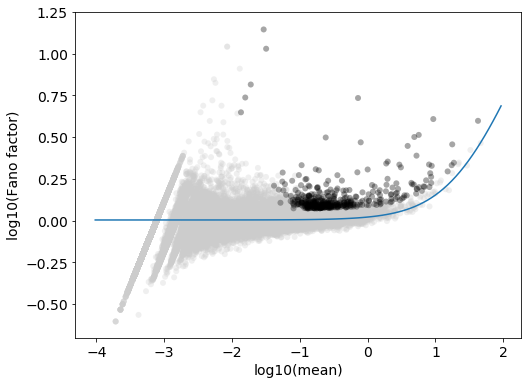

4.97697305679
________________ P11A


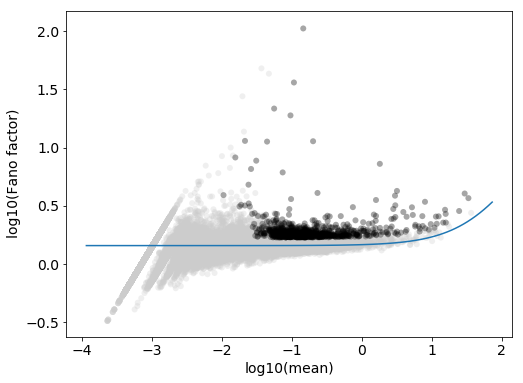

4.57990980148
________________ P11B


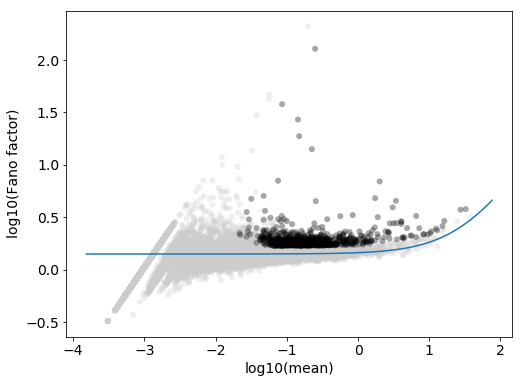

3.67319607735
________________ P12A


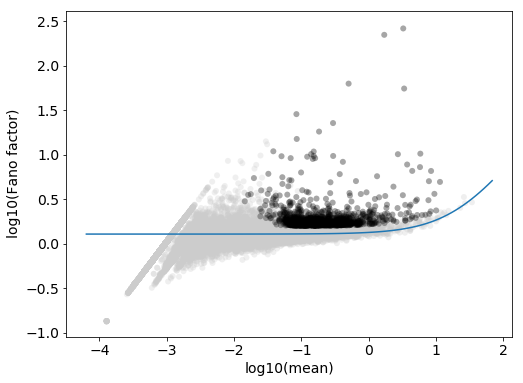

3.84224581718


In [19]:

for s in sample_name:
    t0 = time.time()
    print '________________', s
    
    cell_ix = samp_id_flat == s
    save_path = main_spring_dir + s
    
    out = make_spring_subplot(E[cell_ix,:], gene_list, save_path, 
                        normalize = False, tot_counts_final = total_counts[cell_ix],
                        min_counts = 3, min_cells = 3, min_vscore_pctl = 85,show_vscore_plot = True, 
                        num_pc = 30, 
                        k_neigh = 4, 
                        num_force_iter = 200)

    np.save(save_path + '/cell_filter.npy', np.nonzero(cell_ix)[0])
    np.savetxt(save_path + '/cell_filter.txt', np.nonzero(cell_ix)[0], fmt='%i')

    print time.time() - t0


#### Save merged samples

In [20]:
# set up various merged samples

merge_setup = {'allMerged': sample_name,
               'P11Merged': ['P11A', 'P11B']
               }

________________ P11Merged


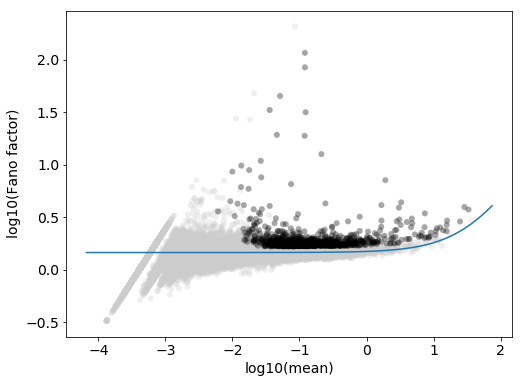

6.9508190155
________________ allMerged


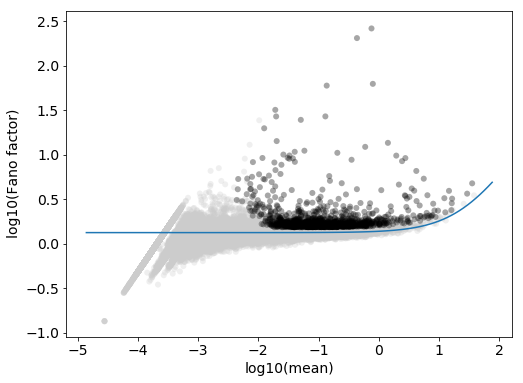

13.721547842


In [21]:
# save data including cell cycle-correlated genes

for s, smerge in merge_setup.items():
    t0 = time.time()
    print '________________', s
    
    cell_ix = np.in1d(samp_id_flat, smerge)
    save_path = main_spring_dir + s
    cell_groupings = {'Sample': list(samp_id_flat[cell_ix])}
    
    out = make_spring_subplot(E[cell_ix,:], gene_list, save_path, 
                        normalize = False, tot_counts_final = total_counts[cell_ix],
                        min_counts = 3, min_cells = 3, min_vscore_pctl = 85,show_vscore_plot = True, 
                        cell_groupings = cell_groupings,
                        num_pc = 30, 
                        k_neigh = 4, 
                        num_force_iter = 200)

    np.save(save_path + '/cell_filter.npy', np.nonzero(cell_ix)[0])
    np.savetxt(save_path + '/cell_filter.txt', np.nonzero(cell_ix)[0], fmt='%i')

    print time.time() - t0


________________ P11Merged


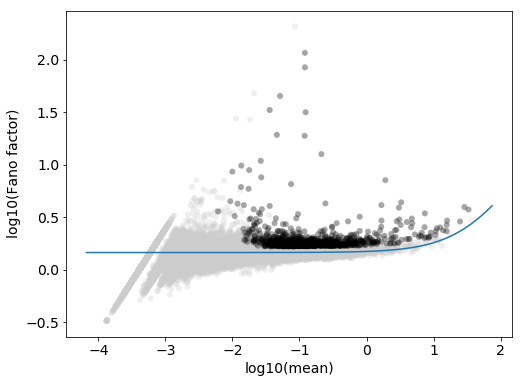

7.85310697556
________________ allMerged


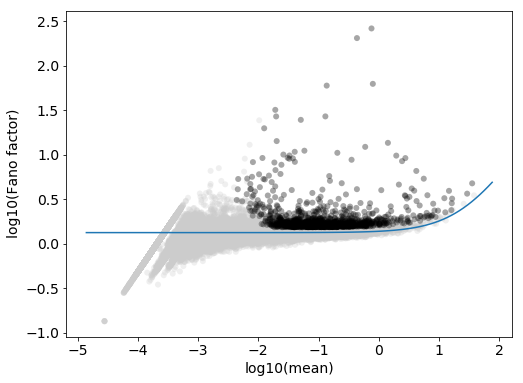

14.7897899151


In [22]:
# save data excluding cell cycle-correlated genes

for s, smerge in merge_setup.items():
    t0 = time.time()
    print '________________', s
    
    cell_ix = np.in1d(samp_id_flat, smerge)
    save_path = main_spring_dir + s + '_noCC'
    cell_groupings = {'Sample': list(samp_id_flat[cell_ix])}
    
    out = make_spring_subplot(E[cell_ix,:], gene_list, save_path, 
                        normalize = False, tot_counts_final = total_counts[cell_ix],
                        min_counts = 3, min_cells = 3, min_vscore_pctl = 85,show_vscore_plot = True, 
                        exclude_corr_genes_list = [cellCycleGenes_G2M], exclude_corr_genes_minCorr = 0.2,
                        cell_groupings = cell_groupings,
                        num_pc = 30, 
                        k_neigh = 4, 
                        num_force_iter = 200)

    np.save(save_path + '/cell_filter.npy', np.nonzero(cell_ix)[0])
    np.savetxt(save_path + '/cell_filter.txt', np.nonzero(cell_ix)[0], fmt='%i')

    print time.time() - t0